In [202]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt

import theano_time_corex
import linearcorex

import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis, PCA

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model

from sklearn.preprocessing import StandardScaler

import sys

import vis_utils
import metric_utils

# Generate Data

In [2]:
nt = 10
m = 8
bs = 8  # bs = 64
nv = m * bs
train_cnt = 8
test_cnt = 100

snr = 5.0
min_var = 1.0
max_var = 1.0

(data1, sigma1) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)
(data2, sigma2) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)

data = data1 + data2
ground_truth = [sigma1 for i in range(nt // 2)] + [sigma2 for i in range(nt // 2)]

X = [x[:train_cnt] for x in data]
Y = [x[train_cnt:] for x in data]

Fixed SNR: 5.0
Fixed SNR: 5.0


## save the data 

In [3]:
all_data = {
    'nt': nt,
    'm': m,
    'bs': bs,
    'nv': nv,
    'train_cnt': train_cnt,
    'test_cnt': test_cnt,
    'X': X,
    'ground_truth': ground_truth,
    'Y': Y,
    'snr': 5.0,
    'min_var': min_var,
    'max_var': max_var,
}
with open("saved_data/synthetic-buckets-nglf.nt{}.nv{}.m{}.ns{}.pkl".format(nt, nv, m, train_cnt), 'wb') as f:
    pkl.dump(all_data, f)

### Ground Truth Covariance 

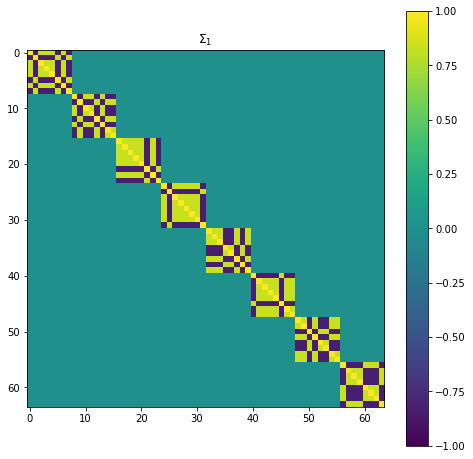

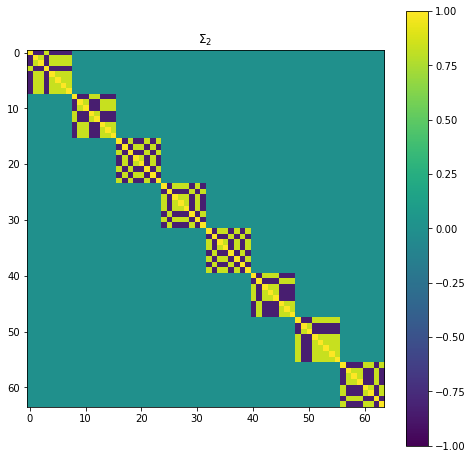

In [186]:
if ground_truth[0] is not None:
    vis_utils.plot_cov_matrix(sigma1, title='$\Sigma_1$')
    vis_utils.plot_cov_matrix(sigma2, title='$\Sigma_2$')

#### Sample covariance matrix using train/test data

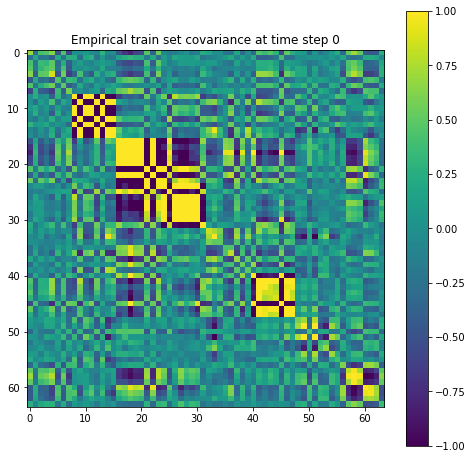

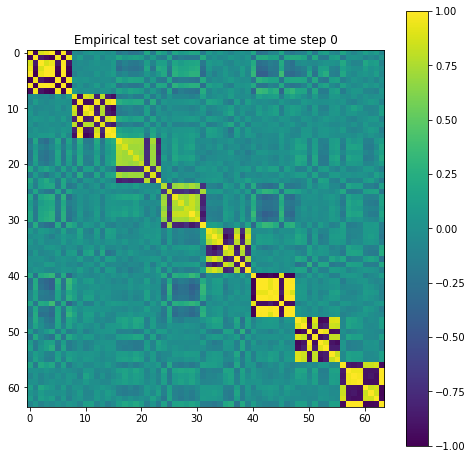

In [187]:
vis_utils.plot_cov_matrix(np.cov(X[0].T), title="Empirical train set covariance at time step 0")
vis_utils.plot_cov_matrix(np.cov(Y[0].T), title="Empirical test set covariance at time step 0")

# Ground Truth Statistics

#### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

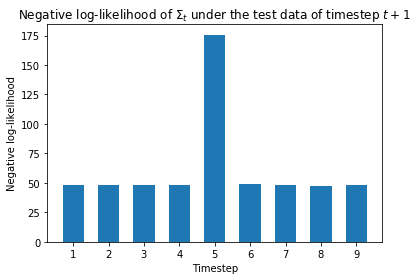

NLL for next time step = 62.2825489733


In [188]:
if ground_truth[0] is not None:
    vis_utils.plot_for_next_timestep(data=Y, covs=ground_truth, title="Negative log-likelihood of $\Sigma_t$ under the test data of timestep $t + 1$")

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [189]:
if ground_truth[0] is not None:
    print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=ground_truth))

Final NLL = 48.3678825325


# Learn independent linear corexes on each timestep

In [190]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=m,
                          max_iter=500,
                          anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

652.497579575


In [191]:
cs_covs = [c.get_covariance() for c in cs]

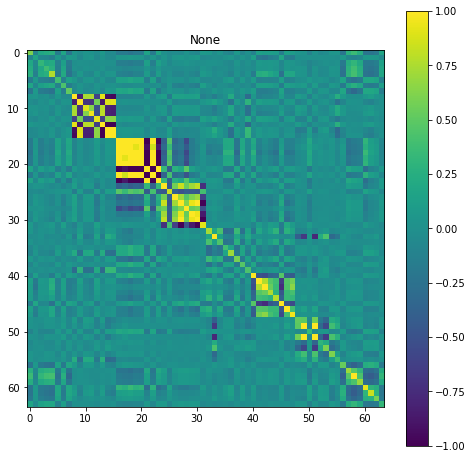

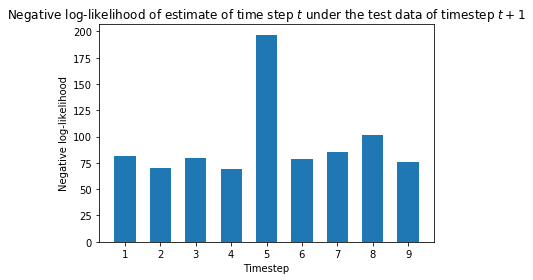

NLL for next time step = 93.2745429193


In [192]:
vis_utils.plot_cov_matrix(cs_covs[0])
vis_utils.plot_for_next_timestep(data=Y, covs=cs_covs);

In [193]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=cs_covs))

Final NLL = 83.2354281402


# L1 regularization on the difference of neighbouring covariance estimates

In [198]:
best_nll = np.inf
best_csig = None
best_l1 = None
#coefs = [0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
coefs=[0.03]
nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = calculate_score(csig_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 0.03
Annealing iteration finished, time = 1.81731510162
Annealing iteration finished, time = 1.75890493393
Annealing iteration finished, time = 1.79643893242
Annealing iteration finished, time = 1.81692504883
Annealing iteration finished, time = 1.80197191238
Annealing iteration finished, time = 1.80808997154
Annealing iteration finished, time = 1.72687005997
l1 = 0.03, nll = 72.0599879976
best l1 = 0.03
613.258318598


In [199]:
csig_covs = csig.get_covariance()

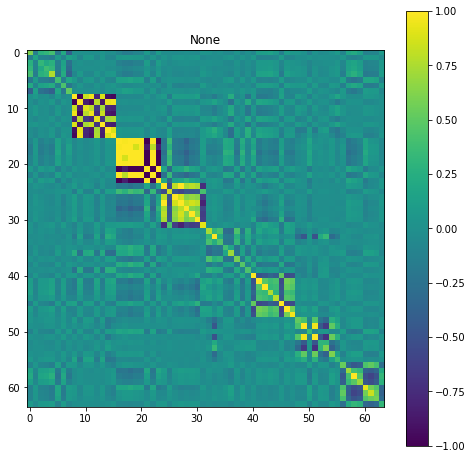

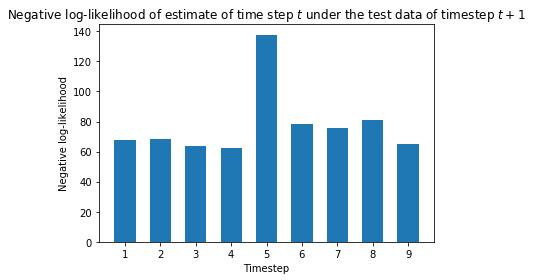

NLL for next time step = 77.6445361301


In [200]:
vis_utils.plot_cov_matrix(csig_covs[0])
vis_utils.plot_for_next_timestep(data=Y, covs=csig_covs);

In [201]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=csig_covs))

Final NLL = 72.0599879976


# Diagonal matrix

In [169]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

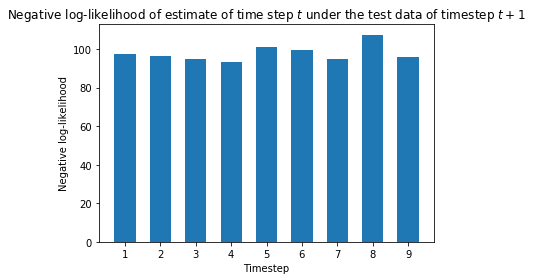

NLL for next time step = 97.8650848881


In [170]:
vis_utils.plot_for_next_timestep(data=Y, covs=diag_covs);

In [171]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=diag_covs))

Final NLL = 98.5831506388


## Ledoit-Wolf Estimation

In [23]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

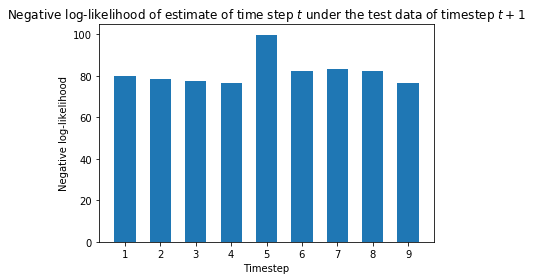

NLL for next time step = 81.8690013507


In [172]:
vis_utils.plot_for_next_timestep(data=Y, covs=lw_covs);

In [174]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=lw_covs))

Final NLL = 79.6438983768


## Oracle Approximating Shrinkage

In [26]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

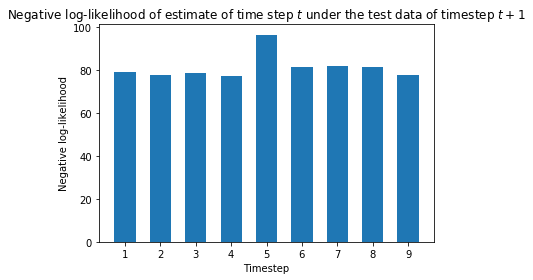

NLL for next time step = 81.2078545074


In [175]:
vis_utils.plot_for_next_timestep(data=Y, covs=oas_covs);

In [176]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=oas_covs))

Final NLL = 79.3443047261


# PCA

In [204]:
pca_covs = []
for x in X:
    pca_est = PCA(n_components=m)
    pca_est.fit(x)
    pca_covs.append(pca_est.get_covariance())

In [205]:
vis_utils.plot_for_next_timestep(data=Y, covs=pca_covs);

LinAlgError: singular matrix

In [207]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=pca_covs))

LinAlgError: singular matrix

# Factor Analysis

In [91]:
factor_covs = []
for x in X:
    factor_est = FactorAnalysis(n_components=m)
    factor_est.fit(x)
    factor_covs.append(factor_est.get_covariance())

In [92]:
# factor_covs = [x + 1e-6 * np.eye(nv) for x in factor_covs]

In [177]:
vis_utils.plot_for_next_timestep(data=Y, covs=factor_covs);

LinAlgError: singular matrix

In [178]:
print "Final NLL = {}".format(matric_utils.calculate_nll_score(data=Y, covs=factor_covs))

NameError: name 'calculate_nll_score' is not defined

## Graphical LASSO

In [90]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso()
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [179]:
vis_utils.plot_for_next_timestep(data=Y, covs=glasso_covs);

IndexError: list index out of range

In [183]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=glasso_covs))

IndexError: list index out of range

# Time Varying Graphical Lasso

In [106]:
sys.path.append('../TVGL/')
from TVGL import TVGL

In [60]:
cur_data = []
for x in X:
    cur_data += litst(x)
cur_data = np.array(cur_data)

In [81]:
tvgl_covs = TVGL(data=cur_data,
                lengthOfSlice=train_cnt,
                lamb=0.001,
                beta=0.1,
                indexOfPenalty=1,
                verbose=True)

Use l-1 penalty function
10
lambda = 0.001, beta = 0.1
Distributed ADMM (4 processors)


KeyboardInterrupt: 

In [68]:
tvgl_covs=[np.linalg.inv(x) for x in tvgl_covs]

In [181]:
vis_utils.plot_for_next_timestep(data=Y, covs=tvgl_covs);

NameError: name 'tvgl_covs' is not defined

In [182]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=tvgl_covs))

NameError: name 'tvgl_covs' is not defined